Exploring a dataset with information about patients. 
Consider next 8 features to predict the mortality rate:
1. Age
2. ОССН KiLLip
3. HBR (b)
4. Systolic AP(b)
5. Creatine in blood
6. EF Percentage
7. White blood cells count
8. Glucose

# 1. Import required libraries and load the dataset

In [6]:
import numpy as np
import pandas as pd
from IPython.display import display

In [7]:
# Load dataset
raw_data = pd.read_excel('./import/DataSet_V47.xlsx')

columns_in_data = ['Age', 
           'ОССН KiLLip', 
           'ЧСС (b)', 
           'Систолическое АД(b)', 
           'Креатинин', 
           'EF%',
           'Лейкоциты(b)',
           'Глюкоза(a)',
           'начало операции',
           'Дата операции в БД',
           'дата выписки',
           'дата смерти',
           'Исход заболевания']

data=raw_data.loc[(raw_data['STEMI']== 'Да')  & 
                   (raw_data['Наличие в БД']== 'Да')  & 
                  (raw_data['Наличие в файле']== 'Да') &
                   (raw_data['ЧКВ']== 'Да'),
                   columns_in_data]

columns_to_check = ['Age',
                   'ЧСС (b)', 
                   'Систолическое АД(b)', 
                   'Креатинин',
                   'EF%', 
                   'Лейкоциты(b)',  
                   'Глюкоза(a)']

data_no_nan = data.dropna(subset=columns_to_check)

data_no_nan_copy = data_no_nan.copy()
for col_name in ['Дата операции в БД', 'дата выписки', 'дата смерти']:
    new_col_name = f"{col_name}_parsed"
    data_no_nan_copy[new_col_name] = pd.to_datetime(data_no_nan_copy[col_name], errors='coerce')

query_expression = "(not `дата смерти`.isnull() and `Исход заболевания` != 'умер')"

# Applying De Morgan's laws to the query
query_expression_2 = "(`дата смерти`.isnull() or `Исход заболевания` == 'умер')"

# Drop rows that satisfy the query expression
clean_data = data_no_nan_copy.query(query_expression_2)

mask = (
    (clean_data['дата смерти_parsed'].notna()) & 
                (clean_data['дата смерти_parsed'] - clean_data['Дата операции в БД_parsed'] > pd.Timedelta('55 days'))
    | ((clean_data['дата смерти_parsed'].isna()) & 
                (clean_data['Исход заболевания'] == 'умер') & 
                (clean_data['дата выписки_parsed'].notna()) & 
                (clean_data['дата выписки_parsed'] - clean_data['Дата операции в БД_parsed'] > pd.Timedelta('55 days'))
        )
)

rows_to_keep = ~mask
ready_data = clean_data[rows_to_keep]
ready_data.describe()

,Age,ОССН KiLLip,ЧСС (b),Систолическое АД(b),Креатинин,EF%,Лейкоциты(b),Глюкоза(a)
count,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000
mean,62.359788,1.657407,74.564815,133.609788,106.298396,54.633598,11.305430,6.579134
std,10.892925,0.950490,14.805993,24.040857,50.914138,8.940425,3.988858,3.069784
min,26.000000,0.000000,30.000000,15.000000,3.830000,20.000000,0.100000,0.000000
25%,55.000000,1.000000,65.000000,120.000000,83.000000,49.000000,8.500000,5.107500
50%,63.000000,1.000000,72.000000,130.000000,98.755000,56.000000,10.700000,5.800000
75%,70.000000,2.000000,80.000000,150.000000,117.397500,61.000000,13.400000,6.982500
max,92.000000,4.000000,160.000000,240.000000,1354.000000,80.000000,38.800000,77.330000


# 2. Split the dataset into features and target.

In [8]:
X = ready_data[['Age', 
                        'ОССН KiLLip', 
                        'ЧСС (b)', 
                        'Систолическое АД(b)', 
                        'Креатинин', 
                        'EF%', 
                        'Лейкоциты(b)', 
                        'Глюкоза(a)']]
y = ready_data['Исход заболевания'].apply(lambda x: 1 if x == 'умер' else 0)

We want to consider hyper parameters, so we will use three different random_state parameters. 

In [9]:
random_states = [0, 25, 42]

## 3. Random Forest Classfier

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import shap


feature_names = ["Age", "ОССН KiLLip", "HBR (b)", "Systolic AP(b)", "Creatine in blood", "EF Percentage", "White blood cells count", "Glucose"]

feature_importances = pd.DataFrame(index=feature_names)
shap_values_list = []
test_proba_dic = {}

for random_state in random_states:

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

    # Define model
    model = RandomForestClassifier(random_state=random_state)
    
    # Define hyperparameters for grid search
    hyperparameter_grid = {
        'n_estimators': [100, 200, 250, 300], 
        'max_depth': [None, 2, 5, 10, 15, 25], 
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        }


    # Define grid search
    grid_cv = GridSearchCV(estimator=model, 
                           param_grid=hyperparameter_grid,
                           cv=5,
                           scoring='roc_auc')
    
    # Execute grid search
    grid_cv.fit(X_train, y_train)
    
    # Display best parameters
    display(grid_cv.best_params_)
    
    # Retrain the model with the best parameters
    model = RandomForestClassifier(random_state=random_state, 
                                   n_estimators=grid_cv.best_params_['n_estimators'], 
                                   max_depth=grid_cv.best_params_['max_depth'], 
                                   min_samples_split=grid_cv.best_params_['min_samples_split'],
                                   max_features=grid_cv.best_estimator_.max_features,
                                   n_jobs=-1)
    model.fit(X_train, y_train)

    # Predict probabilities
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    test_proba_dic[f"{random_state=}"] = [y_test, y_pred_proba]

    # Calculate SHAP values
    explainer = shap.TreeExplainer(model, X_train)
    shap_values = explainer.shap_values(X_test, check_additivity=False)

    shap_values_list.append(shap_values[0])
    feature_importances[random_state] = model.feature_importances_
    feature_importances[str(random_state)+"_shap"] = np.mean(np.abs(shap_values[1]), axis=0)

# Calculate mean feature importances and SHAP values
feature_importances['mean_importance'] = feature_importances[random_states].mean(axis=1)
feature_importances['mean_shap'] = feature_importances[[str(state) + "_shap" for state in random_states]].mean(axis=1)

{'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 200}

{'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 300}

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 100}

In [11]:
test_proba_dic

{'random_state=0': [2835     0
  9806     0
  7416     0
  4817     0
  2656     0
          ..
  801      0
  1864     0
  11424    0
  7891     0
  5181     0
  Name: Исход заболевания, Length: 605, dtype: int64,
  array([0.00951311, 0.05444393, 0.01402865, 0.0143224 , 0.010979  ,
         0.00989969, 0.01785944, 0.01834179, 0.01247872, 0.41236513,
         0.00949162, 0.0102829 , 0.09736008, 0.06063517, 0.05910945,
         0.01245797, 0.01009935, 0.01085398, 0.01231262, 0.01726162,
         0.02784921, 0.01004197, 0.01296129, 0.01687029, 0.16796441,
         0.40849401, 0.08519306, 0.01764419, 0.01991485, 0.01254437,
         0.02763239, 0.02287552, 0.0113184 , 0.50800208, 0.01421539,
         0.00923197, 0.04458792, 0.19095196, 0.01306074, 0.05767153,
         0.01565338, 0.0320108 , 0.01537616, 0.0230248 , 0.02544791,
         0.01715675, 0.02013285, 0.02841823, 0.01485306, 0.03296679,
         0.00998337, 0.04054865, 0.00982961, 0.03370312, 0.01118741,
         0.01214634, 0.035

In [ ]:

 # Calculate AUC-ROC score
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC-ROC score for random_state {random_state}: {auc_roc}')

In [ ]:
feature_importances

,0,0_shap,25,25_shap,42,42_shap,mean_importance,mean_shap
Age,0.082769,0.007794,0.069562,0.004754,0.064579,0.002487,0.072303,0.005012
ОССН KiLLip,0.045177,0.005570,0.056393,0.004921,0.048377,0.005710,0.049982,0.005401
HBR (b),0.133176,0.015907,0.137465,0.006239,0.138557,0.007269,0.136399,0.009805
Systolic AP(b),0.108868,0.008142,0.084637,0.003130,0.080736,0.002813,0.091413,0.004695
Creatine in blood,0.161756,0.007415,0.151002,0.004582,0.180754,0.007030,0.164504,0.006342
EF Percentage,0.172363,0.010091,0.172103,0.008113,0.173915,0.009212,0.172794,0.009138
White blood cells count,0.124912,0.005573,0.138800,0.004484,0.141886,0.003409,0.135199,0.004489
Glucose,0.170980,0.008643,0.190038,0.009335,0.171198,0.005239,0.177406,0.007739


In [ ]:
import matplotlib.pyplot as plt

def plot_weights (feature_importances, column1, column2, label1, label2, title, num_digits=3):
    barWidth = 0.25

    r1 = np.arange(len(feature_importances[column1]))
    r2 = [x + barWidth for x in r1]

    plt.figure(figsize=(13, 6))
    bars1 = plt.barh(r1, feature_importances[column1], color='blue', height=barWidth, edgecolor='grey', label=label1)
    bars2 = plt.barh(r2, feature_importances[column2], color='orange', height=barWidth, edgecolor='grey', label=label2)

    plt.yticks([r + barWidth for r in range(len(feature_importances[column1]))], feature_importances.index)

    def add_values(bars):
        for bar in bars:
            width = bar.get_width()
            plt.text(width,               
                    bar.get_y() + bar.get_height() / 2.2 ,  
                    f"{width :.{num_digits}f}",  
                    ha='left', va='center')  


    add_values(bars1)
    add_values(bars2)

    plt.xlabel('Score')
    plt.ylabel('Feature')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

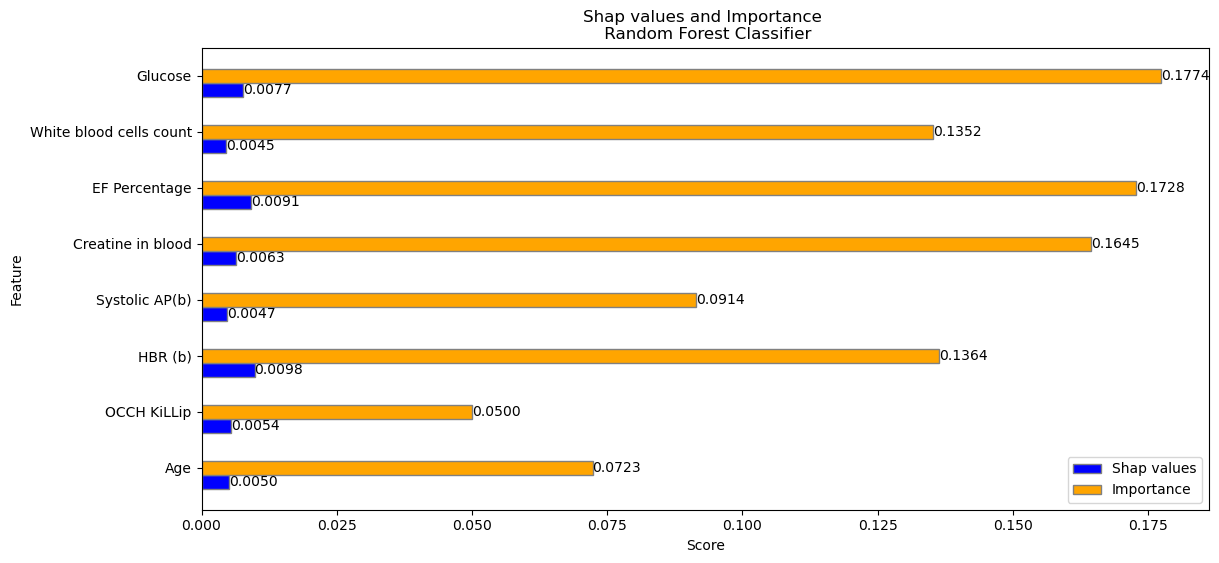

In [ ]:
plot_weights(feature_importances, 
             column1='mean_shap', 
             column2='mean_importance', 
             label1='Shap values', 
             label2='Importance', 
             title='Shap values and Importance \n Random Forest Classifier',
             num_digits=4)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


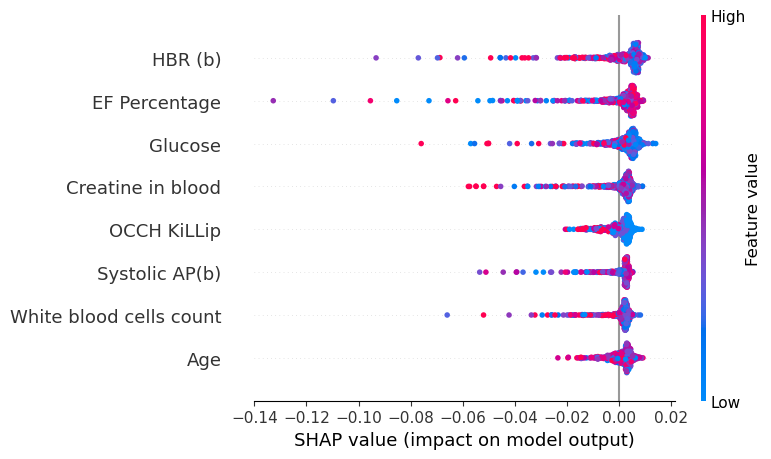

In [ ]:
mean_shap_values = np.mean(shap_values_list, axis=0)
shap.summary_plot(mean_shap_values, X_test, feature_names=feature_names)